In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import itertools
# import NOTEARS
import nt_linear as nt
from dag_generator import DAGGenerator
from sklearn.preprocessing import scale
import scipy
from matplotlib import animation
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import seaborn as sns
import os

In [76]:
X_0 = np.random.normal(0, 1, 10000)
X_1 = 7*X_0 + np.random.normal(0, 1, 10000)
X_2 = 5*X_1 + np.random.normal(0, 1, 10000)

In [77]:
s_X_0 = scale(X_0)
s_X_1 = scale(X_1)
s_X_2 = scale(X_2)

In [78]:
data = np.array([X_0, X_1, X_2])
sdata = np.array([s_X_0, s_X_1, s_X_2])
a_X_0 = 2*s_X_0
adata = np.array([a_X_0, s_X_1, s_X_2])

In [79]:
np.cov(data)

array([[1.01715692e+00, 7.12603298e+00, 3.56428876e+01],
       [7.12603298e+00, 5.09115475e+01, 2.54642278e+02],
       [3.56428876e+01, 2.54642278e+02, 1.27465257e+03]])

In [80]:
np.cov(sdata)

array([[1.00010001, 0.99035097, 0.98998   ],
       [0.99035097, 1.00010001, 0.99970043],
       [0.98998   , 0.99970043, 1.00010001]])

In [81]:
np.cov(adata)

array([[4.00040004, 1.98070194, 1.97996   ],
       [1.98070194, 1.00010001, 0.99970043],
       [1.97996   , 0.99970043, 1.00010001]])

In [83]:
from sklearn.linear_model import Lasso

In [92]:
l1, l2, l3 = Lasso(0.01), Lasso(0.01), Lasso(0.01)
l1.fit(data.T[:, 0:2], data.T[:, 2])
l1.coef_

array([0.        , 5.00146409])

In [93]:
l2.fit(sdata.T[:, 0:2], sdata.T[:, 2])
l2.coef_

array([0.00120941, 0.98840285])

In [94]:
l3.fit(adata.T[:, 0:2], adata.T[:, 2])
l3.coef_

array([0.12882616, 0.73445976])

In [63]:
# NOTE: Only execute this if the metadata-file hasn't been built yet!
dfs = []
for filename in os.listdir('./experiments/flip-experiment-fixed-data-as4-reg1/'):
    if 'metadata' in filename:
        df = pd.read_csv('./experiments/flip-experiment-fixed-data-as4-reg1/{}'.format(filename), index_col=0)
        dfs.append(df)
final_df = pd.concat(dfs)
exp_ids = np.arange(0, len(final_df))
final_df['Exp'] = exp_ids
final_df

FileNotFoundError: [Errno 2] No such file or directory: './experiments/flip-experiment-fixed-data-as4-reg1/'

In [62]:
final_df['adj_nr'] = final_df.index
final_df

,s_1,s_2,Exp,pid,success,adj_nr
0,-8.90,4.40,0,443993,0,0
1,-9.45,1.05,1,443993,1,1
2,-9.45,-8.35,2,443993,0,2
3,-9.55,9.65,3,443993,0,3
4,-9.70,-6.80,4,443993,0,4
...,...,...,...,...,...,...
9995,-2.00,5.90,159995,443999,1,9995
9996,-1.90,-7.20,159996,443999,0,9996
9997,-1.65,-8.40,159997,443999,0,9997
9998,-1.85,-9.70,159998,443999,0,9998


In [54]:
final_df.to_csv('./experiments/flip-experiment-fixed-data-as4-reg0.01/metadata.csv')

## Load metadata

In [55]:
metadata_df = pd.read_csv('./experiments/flip-experiment-fixed-data-as4-reg0.01/metadata.csv', index_col=0)
metadata_df['scale_diff'] = metadata_df['s_1'] - metadata_df['s_2']
metadata_df

,s_1,s_2,Exp,pid,success,adj_nr,scale_diff
0,-8.90,4.40,0,443993,0,0,-13.30
1,-9.45,1.05,1,443993,1,1,-10.50
2,-9.45,-8.35,2,443993,0,2,-1.10
3,-9.55,9.65,3,443993,0,3,-19.20
4,-9.70,-6.80,4,443993,0,4,-2.90
...,...,...,...,...,...,...,...
9995,-2.00,5.90,159995,443999,1,9995,-7.90
9996,-1.90,-7.20,159996,443999,0,9996,5.30
9997,-1.65,-8.40,159997,443999,0,9997,6.75
9998,-1.85,-9.70,159998,443999,0,9998,7.85


## Success-Failure grouping
The following plot shows the success (blue) or failure (red) of NOTEARS for a given pair of coefficients by which the data was scaled in the data generating process.

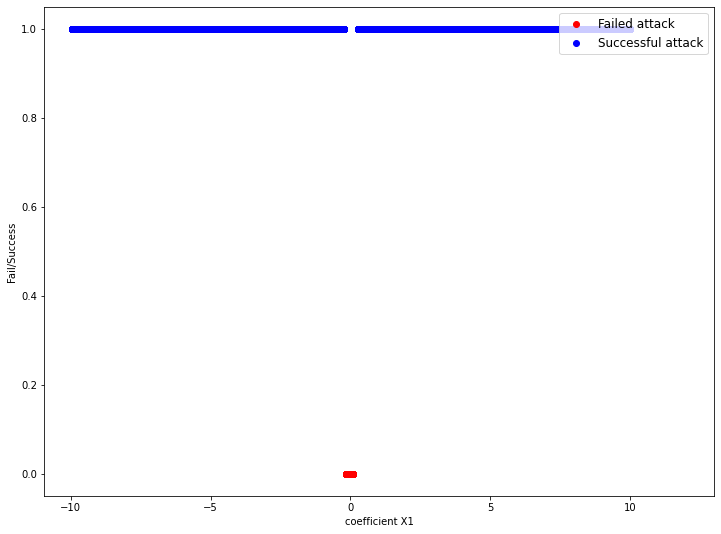

In [25]:
failed_attacks = metadata_df[metadata_df['success'] == 0]
success_attacks = metadata_df[metadata_df['success'] == 1]
positive_diffs = metadata_df[metadata_df['scale_diff'] >= 0]
negative_diffs = metadata_df[metadata_df['scale_diff'] < 0]
diagonal = np.arange(metadata_df['s_1'].min(), metadata_df['s_1'].max())
fig = plt.figure(figsize=(12, 9))
plt.scatter(failed_attacks['s_1'], np.zeros(len(failed_attacks)), color='red', label='Failed attack')
plt.scatter(success_attacks['s_1'], np.ones(len(success_attacks)), color='blue', label='Successful attack')
# plt.scatter(positive_diffs['s_1'], np.zeros(len(positive_diffs)), color='yellow', s=500, alpha=0.01, label='Positive coefficient-diff')
# plt.scatter(negative_diffs['s_1'], np.zeros(len(negative_diffs)), color='brown', s=500, alpha=0.01, label='Negative coefficient-diff')
plt.xlabel('coefficient X1')
plt.ylabel('Fail/Success')
plt.xlim([metadata_df['s_1'].min()- 1, metadata_df['s_1'].max() + 3])
plt.legend(loc='upper right', prop={'size': 12})
plt.show()

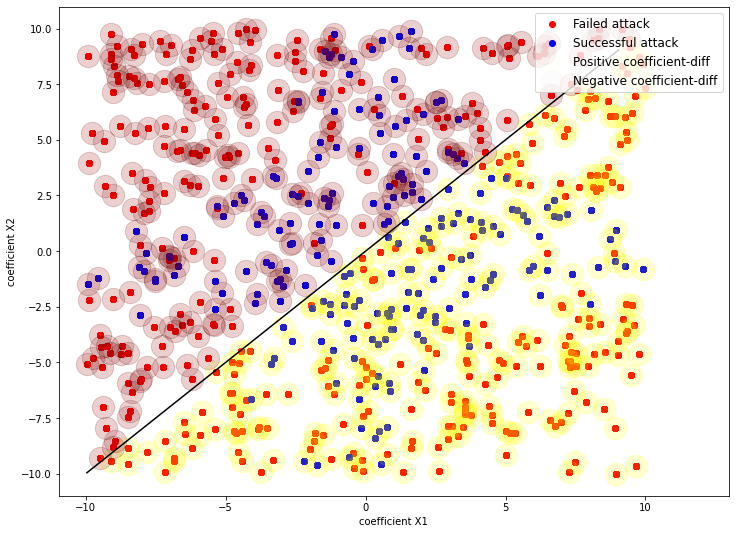

In [3]:
failed_attacks = metadata_df[metadata_df['success'] == 0]
success_attacks = metadata_df[metadata_df['success'] == 1]
positive_diffs = metadata_df[metadata_df['scale_diff'] >= 0]
negative_diffs = metadata_df[metadata_df['scale_diff'] < 0]
diagonal = np.arange(metadata_df['s_1'].min(), metadata_df['s_1'].max())
fig = plt.figure(figsize=(12, 9))
plt.scatter(failed_attacks['s_1'], failed_attacks['s_2'], color='red', label='Failed attack')
plt.scatter(success_attacks['s_1'], success_attacks['s_2'], color='blue', label='Successful attack')
plt.scatter(positive_diffs['s_1'], positive_diffs['s_2'], color='yellow', s=500, alpha=0.01, label='Positive coefficient-diff')
plt.scatter(negative_diffs['s_1'], negative_diffs['s_2'], color='brown', s=500, alpha=0.01, label='Negative coefficient-diff')
plt.plot(diagonal, diagonal, color='black')
plt.xlabel('coefficient X1')
plt.ylabel('coefficient X2')
plt.xlim([metadata_df['s_1'].min()- 1, metadata_df['s_1'].max() + 3])
plt.legend(loc='upper right', prop={'size': 12})
plt.show()

## Analyzing gradients
In the following section the development of the gradients over time is considered for both, successful and failing attacks. The gradients of the loss-function (i.e. MSE) and the acyclicity constraint are considered separately for better overview. The hope is that we can identify patterns in the gradients which differ between successful and failing attacks.

In [13]:
exp_num = 5
mse_gradient_df = pd.read_csv('./experiments/flip-experiment/gradients_{}/loss_gradients.csv'.format(exp_num), index_col=0)
acyc_gradient_df = pd.read_csv('./experiments/flip-experiment/gradients_{}/acyclicity_gradients.csv'.format(exp_num), index_col=0)
acyc_loss = pd.read_csv('./experiments/flip-experiment/gradients_{}/acyclicity_losses.csv'.format(exp_num), index_col=0)
loss_df = pd.read_csv('./experiments/flip-experiment/gradients_{}/losses.csv'.format(exp_num), index_col=0)
loss = loss_df['loss'].to_numpy()
acyc_loss = acyc_loss['loss'].to_numpy()

In [12]:
metadata_df[metadata_df['success'] == 1]

,s_1,s_2,Exp,pid,success,adj_nr,scale_diff
5,8.004157,-2.357135,5,32058,1,5,10.361293
7,2.055751,-2.636765,7,32058,1,7,4.692516
8,1.013616,7.722400,8,32058,1,8,-6.708784
9,2.482236,-3.197369,9,32058,1,9,5.679605
14,7.368189,-1.008920,14,32058,1,14,8.377109
...,...,...,...,...,...,...,...
617,9.924663,-0.783495,9992,32053,1,617,10.708158
618,-2.704130,0.306805,9993,32053,1,618,-3.010935
619,2.101349,-5.363597,9994,32053,1,619,7.464945
622,-0.403638,-2.475467,9997,32053,1,622,2.071829


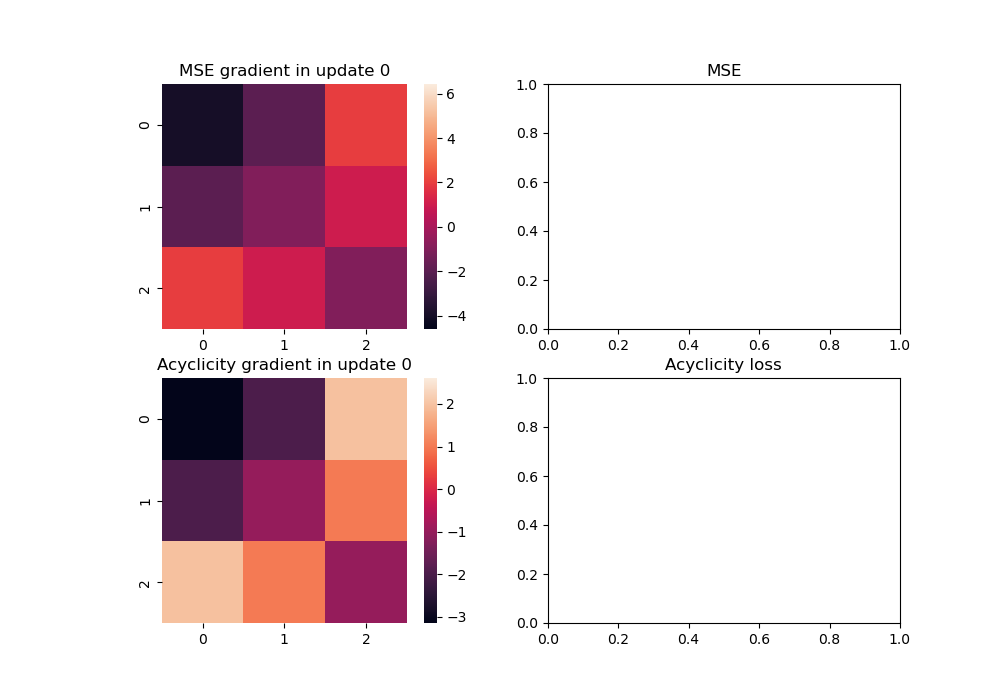

In [14]:
%matplotlib ipympl
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
mse_vmin = mse_gradient_df[['0', '1', '2']].min().min()
mse_vmax = mse_gradient_df[['0', '1', '2']].max().max()
acyc_vmin = acyc_gradient_df[['0', '1', '2']].min().min()
acyc_vmax = acyc_gradient_df[['0', '1', '2']].max().max()
mse_hax, mse_lax = axs[0]
acyc_hax, acyc_lax = axs[1]
sns.heatmap(mse_gradient_df[mse_gradient_df['t'] == 0][['0', '1', '2']],  vmin=mse_vmin, vmax=mse_vmax, square=True, cbar=True, ax=mse_hax)
sns.heatmap(mse_gradient_df[mse_gradient_df['t'] == 0][['0', '1', '2']],  vmin=acyc_vmin, vmax=acyc_vmax, square=True, cbar=True, ax=acyc_hax)
mse_hax.set_title('MSE gradient in update 0')
acyc_hax.set_title('Acyclicity gradient in update 0')
mse_lax.set_title('MSE')
acyc_lax.set_title('Acyclicity loss')

def animate(i):
    mse_grad = mse_gradient_df[mse_gradient_df['t'] == i][['0', '1', '2']]
    acyc_grad = acyc_gradient_df[acyc_gradient_df['t'] == i][['0', '1', '2']]
    sns.heatmap(mse_grad, square=True, cbar=False, ax=mse_hax)
    sns.heatmap(acyc_grad, square=True, cbar=False, ax=acyc_hax)
    mse_hax.set_title('MSE gradient in update {}'.format(i))
    acyc_hax.set_title('Acyclicity gradient in update {}'.format(i))

    mse_lax.cla()
    mse_lax.plot(np.arange(0, i), loss[:i])
    acyc_lax.cla()
    acyc_lax.plot(np.arange(0, i), acyc_loss[:i])

def init():
    sns.heatmap(np.zeros((3, 3)), cbar=False, ax=mse_hax)
    sns.heatmap(np.zeros((3, 3)), cbar=False, ax=acyc_hax)
    

frames = min(len(acyc_loss), len(loss))
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=0, repeat=False)
plt.show()

The following plot shows the the gradient of the loss and of the acylcicity constraint in the last iteration of NOTEARS. Further the predicted graph and the expected (in terms of varsortability) is plotted.

In [56]:
loss_gradient_path = './experiments/flip-experiment-fixed-data-as4-reg0.01/gradients_{}/loss_gradients.csv'
acyc_gradient_path = './experiments/flip-experiment-fixed-data-as4-reg0.01/gradients_{}/acyclicity_gradients.csv'
adj_path = './experiments/flip-experiment-fixed-data-as4-reg0.01/adjacencies_{}/adj_{}.csv'

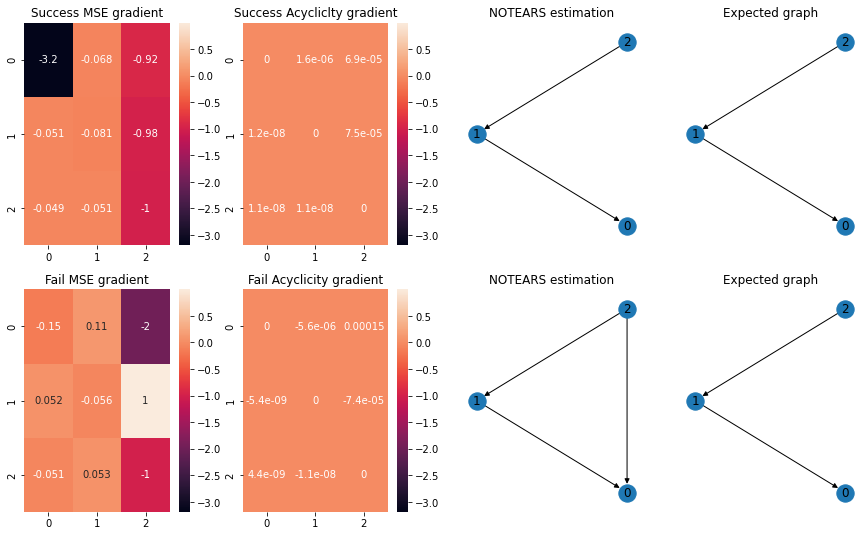

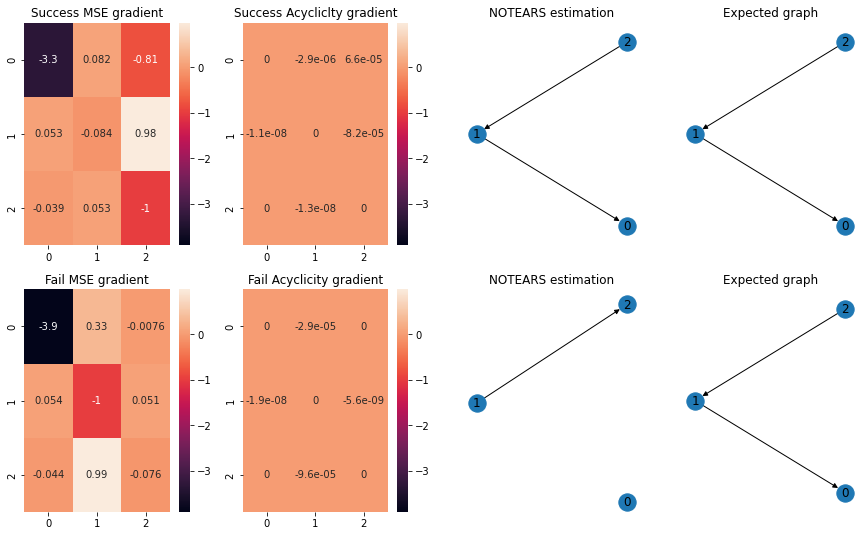

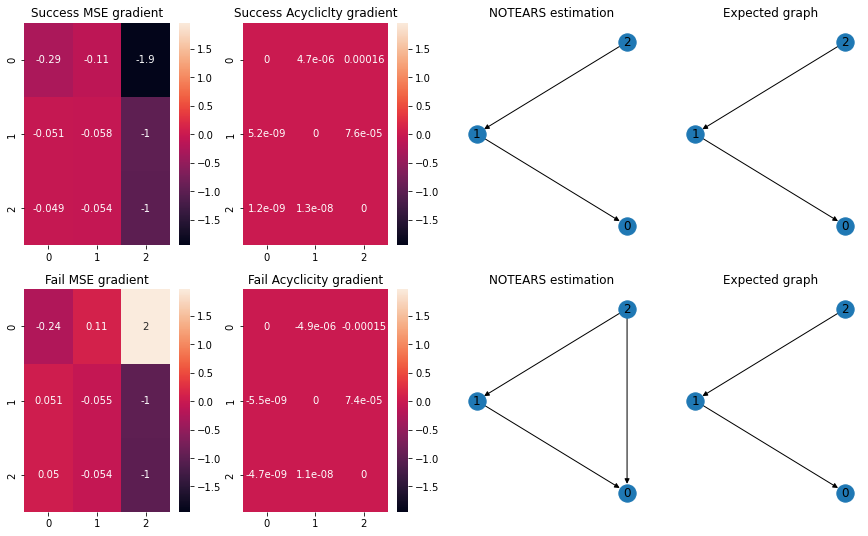

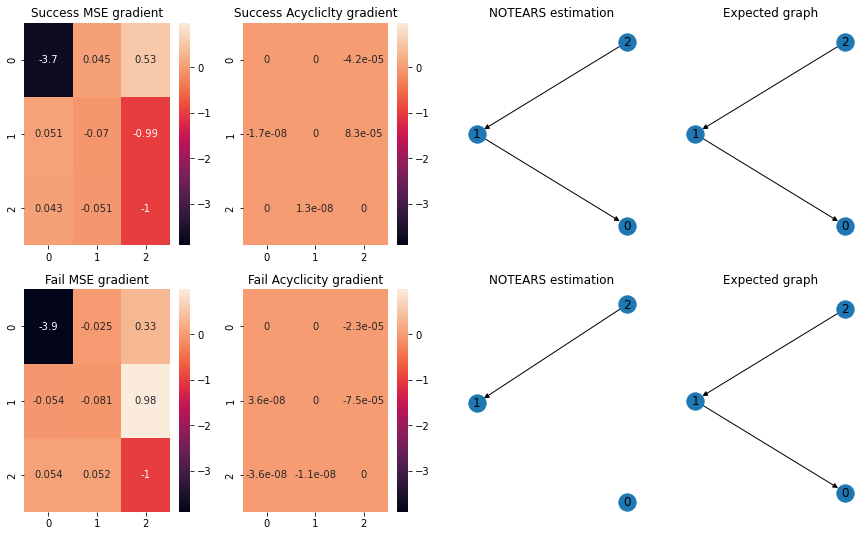

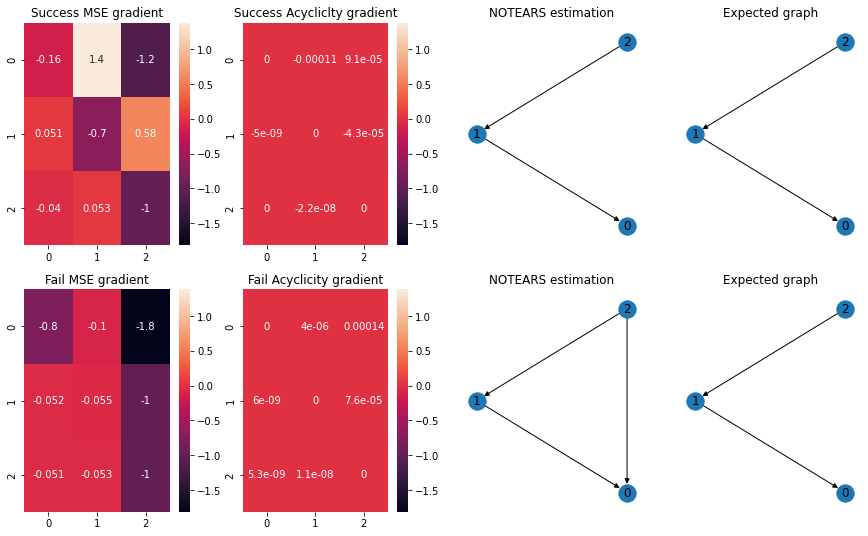

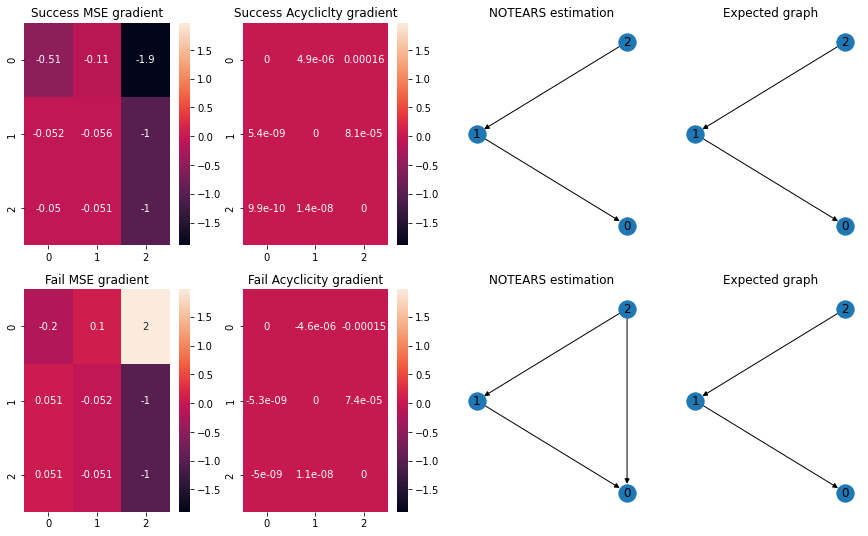

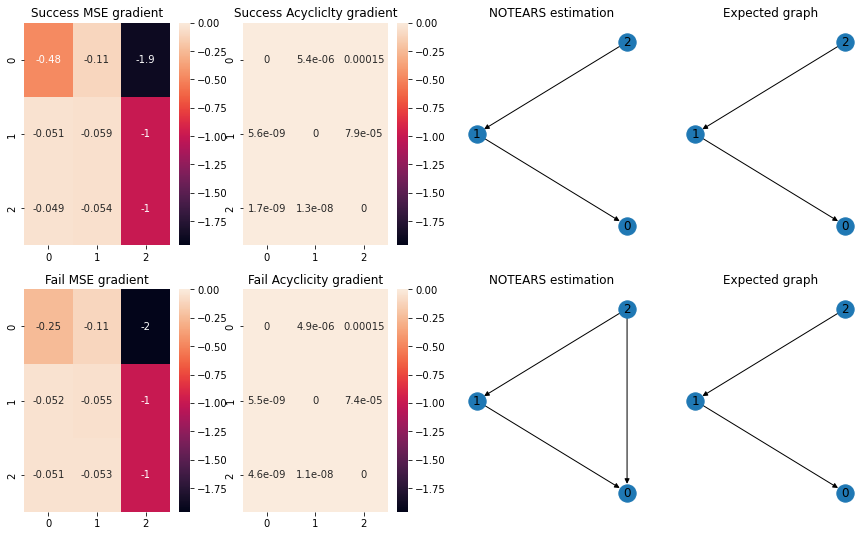

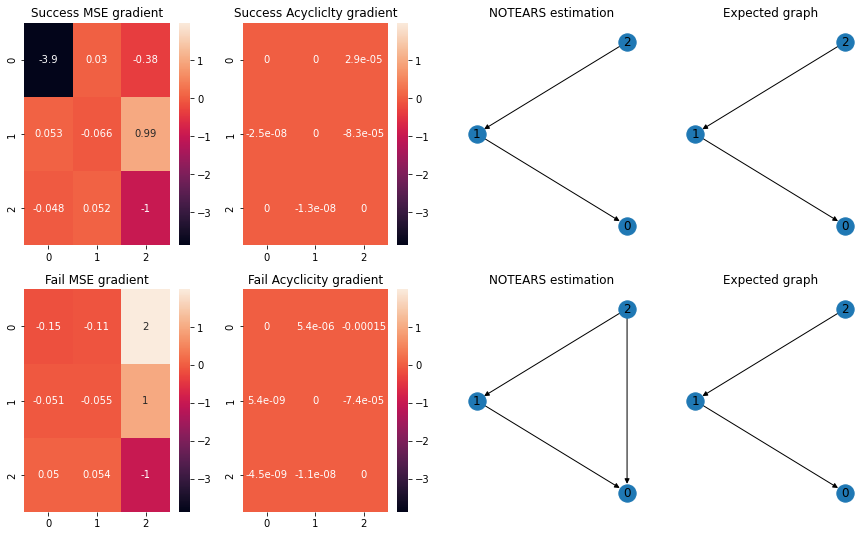

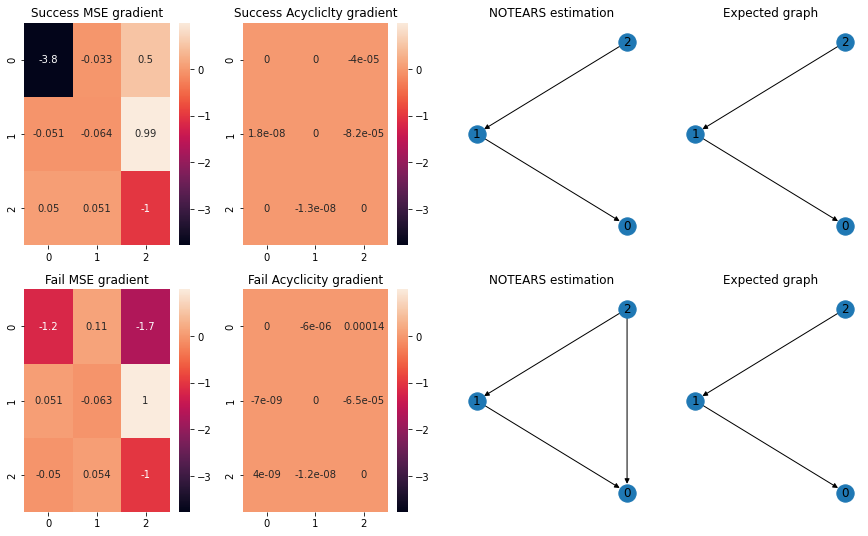

In [7]:
success_attacks = metadata_df[metadata_df['success'] == 1]
failed_attacks = metadata_df[metadata_df['success'] == 0]
G_true = nx.DiGraph()
G_true.add_edges_from([(1, 0), (2, 1)])
pos = nx.shell_layout(G_true)
for i in range(11, 20):
    # get information to obtain data for plot
    success_exp = int(success_attacks.iloc[i]['Exp'])
    failed_exp = int(failed_attacks.iloc[i]['Exp'])
    success_pid = int(success_attacks.iloc[i]['pid'])
    failed_pid = int(failed_attacks.iloc[i]['pid'])
    success_adj_nr = int(success_attacks.iloc[i]['adj_nr'])
    failed_adj_nr = int(failed_attacks.iloc[i]['adj_nr'])

    # read data
    suc_mse_gradient_df = pd.read_csv(loss_gradient_path.format(success_exp), index_col=0)
    suc_acyc_gradient_df = pd.read_csv(acyc_gradient_path.format(success_exp), index_col=0)
    fail_mse_gradient_df = pd.read_csv(loss_gradient_path.format(failed_exp), index_col=0)
    fail_acyc_gradient_df = pd.read_csv(acyc_gradient_path.format(failed_exp), index_col=0)
    suc_adj = pd.read_csv(adj_path.format(success_pid, success_adj_nr), index_col=0)
    fail_adj = pd.read_csv(adj_path.format(failed_pid, failed_adj_nr), index_col=0)

    # get last 3 rows of the gradient-dataset, i.e. the gradient of the last iteration of NT
    last_suc_mse_grad = suc_mse_gradient_df.tail(3)[['0', '1', '2']]
    last_suc_acyc_grad = suc_acyc_gradient_df.tail(3)[['0', '1', '2']]
    last_fail_mse_grad = fail_mse_gradient_df.tail(3)[['0', '1', '2']]
    last_fail_acyc_grad = fail_acyc_gradient_df.tail(3)[['0', '1', '2']]

    fig, axs = plt.subplots(2, 4, figsize=(15, 9))
    suc_mse_hax, suc_acyc_hax, suc_gax, t_gax1 = axs[0]
    fail_mse_hax, fail_acyc_hax, fail_gax, t_gax2 = axs[1]
    suc_mse_hax.set_title('Success MSE gradient')
    suc_acyc_hax.set_title('Success Acycliclty gradient')
    fail_mse_hax.set_title('Fail MSE gradient')
    fail_acyc_hax.set_title('Fail Acyclicity gradient')
    t_gax1.set_title('Expected graph')
    t_gax2.set_title('Expected graph')
    suc_gax.set_title('NOTEARS estimation')
    fail_gax.set_title('NOTEARS estimation')

    vmin = min(last_suc_mse_grad.min().min(), last_suc_acyc_grad.min().min(), last_fail_mse_grad.min().min(), last_fail_acyc_grad.min().min())
    vmax = max(last_suc_mse_grad.max().max(), last_suc_acyc_grad.max().max(), last_fail_mse_grad.max().max(), last_fail_acyc_grad.max().max())

    sns.heatmap(last_suc_mse_grad, vmin=vmin, vmax=vmax, ax=suc_mse_hax, annot=True)
    sns.heatmap(last_suc_acyc_grad, vmin=vmin, vmax=vmax, ax=suc_acyc_hax, annot=True)
    sns.heatmap(last_fail_mse_grad, vmin=vmin, vmax=vmax, ax=fail_mse_hax, annot=True)
    sns.heatmap(last_fail_acyc_grad, vmin=vmin, vmax=vmax, ax=fail_acyc_hax, annot=True)

    G_suc = nx.convert_matrix.from_numpy_array(suc_adj.to_numpy(), create_using=nx.DiGraph)
    G_fail = nx.convert_matrix.from_numpy_array(fail_adj.to_numpy(), create_using=nx.DiGraph)

    nx.draw(G_suc, pos, with_labels=True, ax=suc_gax)
    nx.draw(G_fail, pos, with_labels=True, ax=fail_gax)
    nx.draw(G_true, pos, with_labels=True, ax=t_gax1)
    nx.draw(G_true, pos, with_labels=True, ax=t_gax2)

In [18]:
experiment_nums = list(range(0, 10))
predictions = []
for exp_num in experiment_nums:
    scales = np.random.uniform(-10, 10, 2)
    # generate data according to a causal graph X0 -> X1 -> X2
    X0 = np.random.normal(0, 1, 1000)
    X1 = scales[0]*X0 + np.random.normal(0, 1, 1000)
    X2 = scales[1]*X1 + np.random.normal(0, 1, 1000)
    # scale data s.t. we lose varsortability information
    gdata = np.array([X0, X1, X2]).T
    gradient_log_dir = './experiments/flip-experiment-unscaled/gradients_{}/'.format(exp_num)
    os.mkdir(gradient_log_dir)
    nt_pred = nt.notears_linear(gdata, 0.05, 'l2', log_gradients=True, gradient_log_dir=gradient_log_dir, rand_init=True)
    nt_pred[nt_pred != 0] = 1
    predictions.append(nt_pred)

In [20]:
loss_gradient_path = './experiments/flip-experiment-unscaled/gradients_{}/loss_gradients.csv'
acyc_gradient_path = './experiments/flip-experiment-unscaled/gradients_{}/acyclicity_gradients.csv'

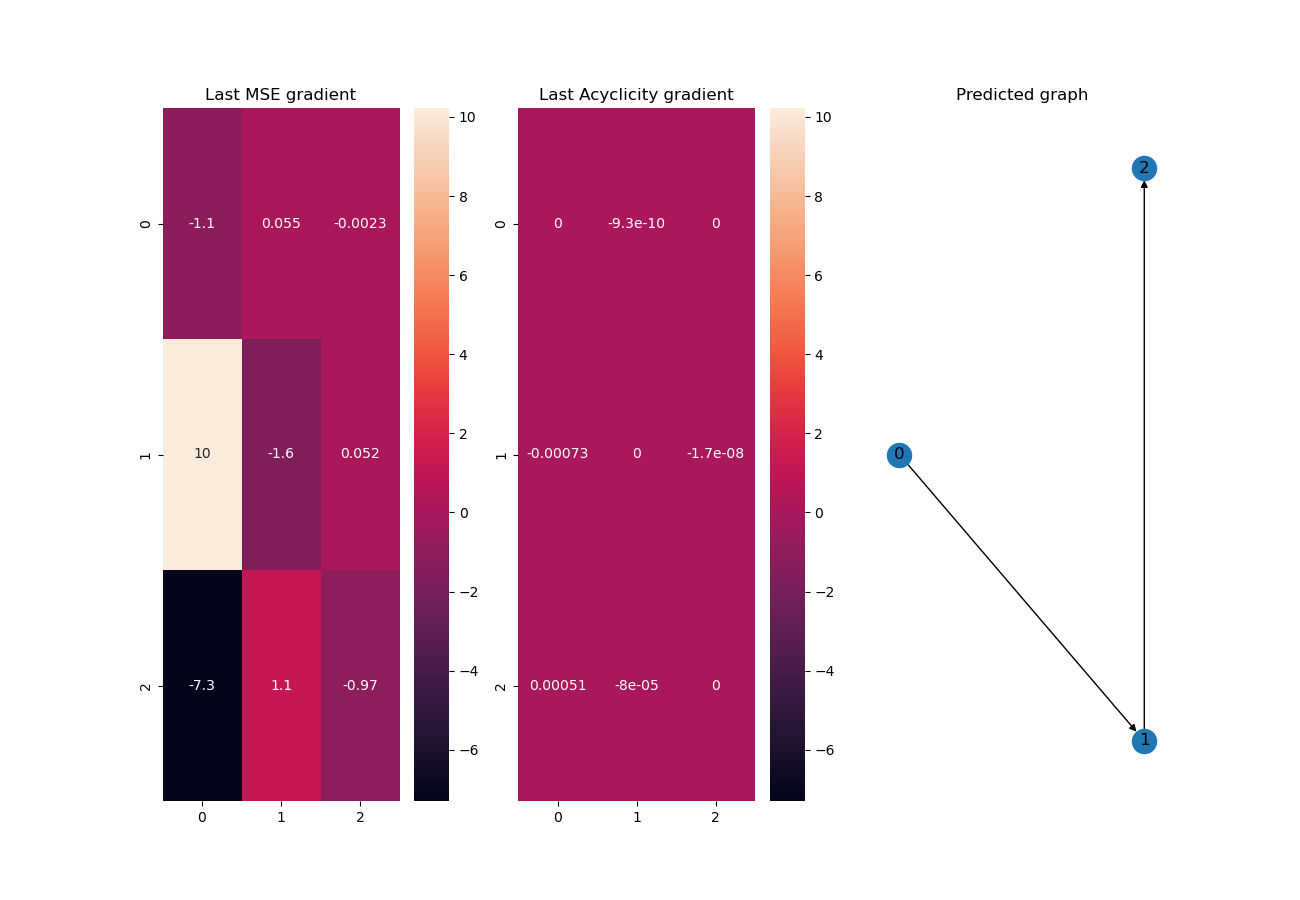

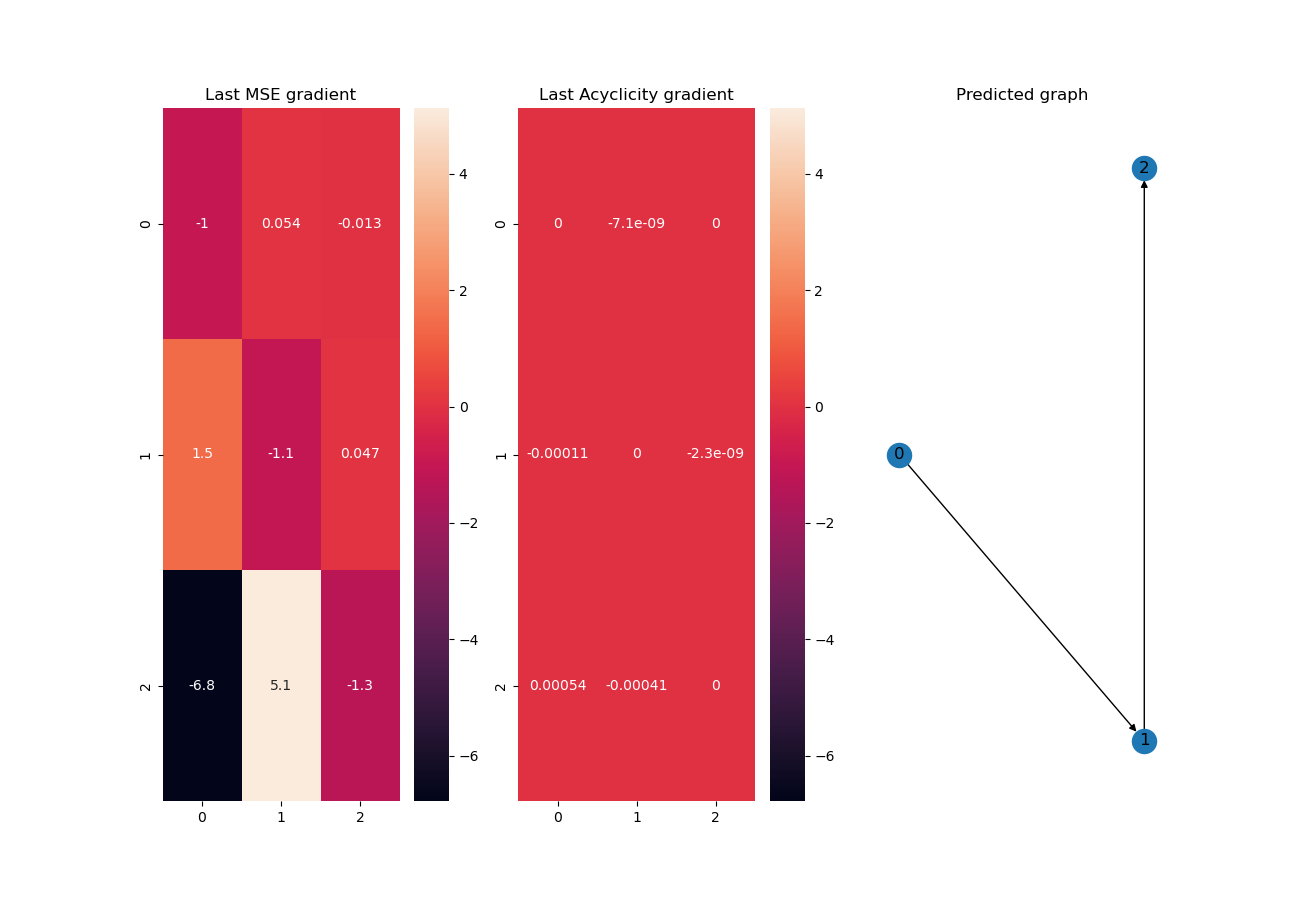

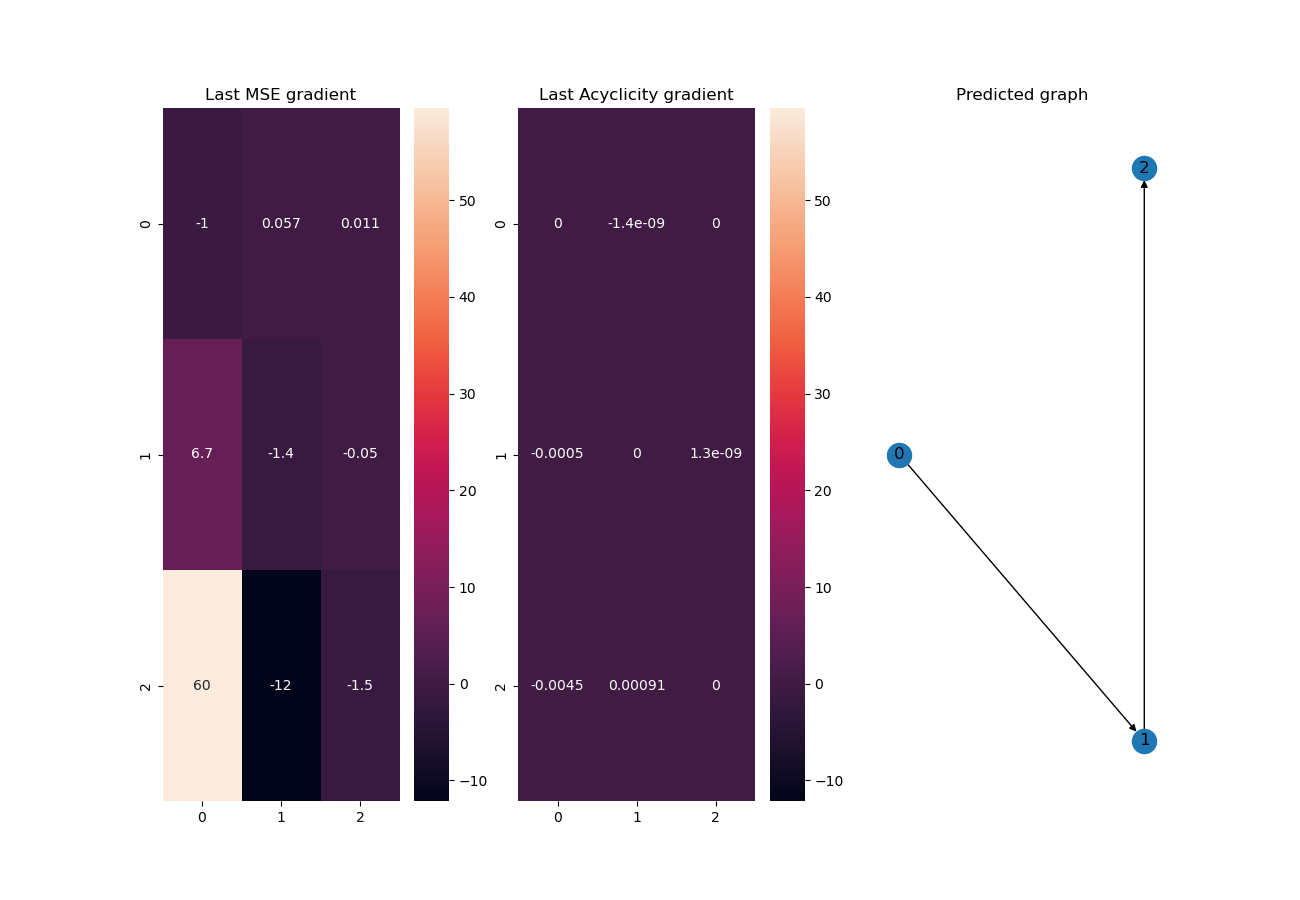

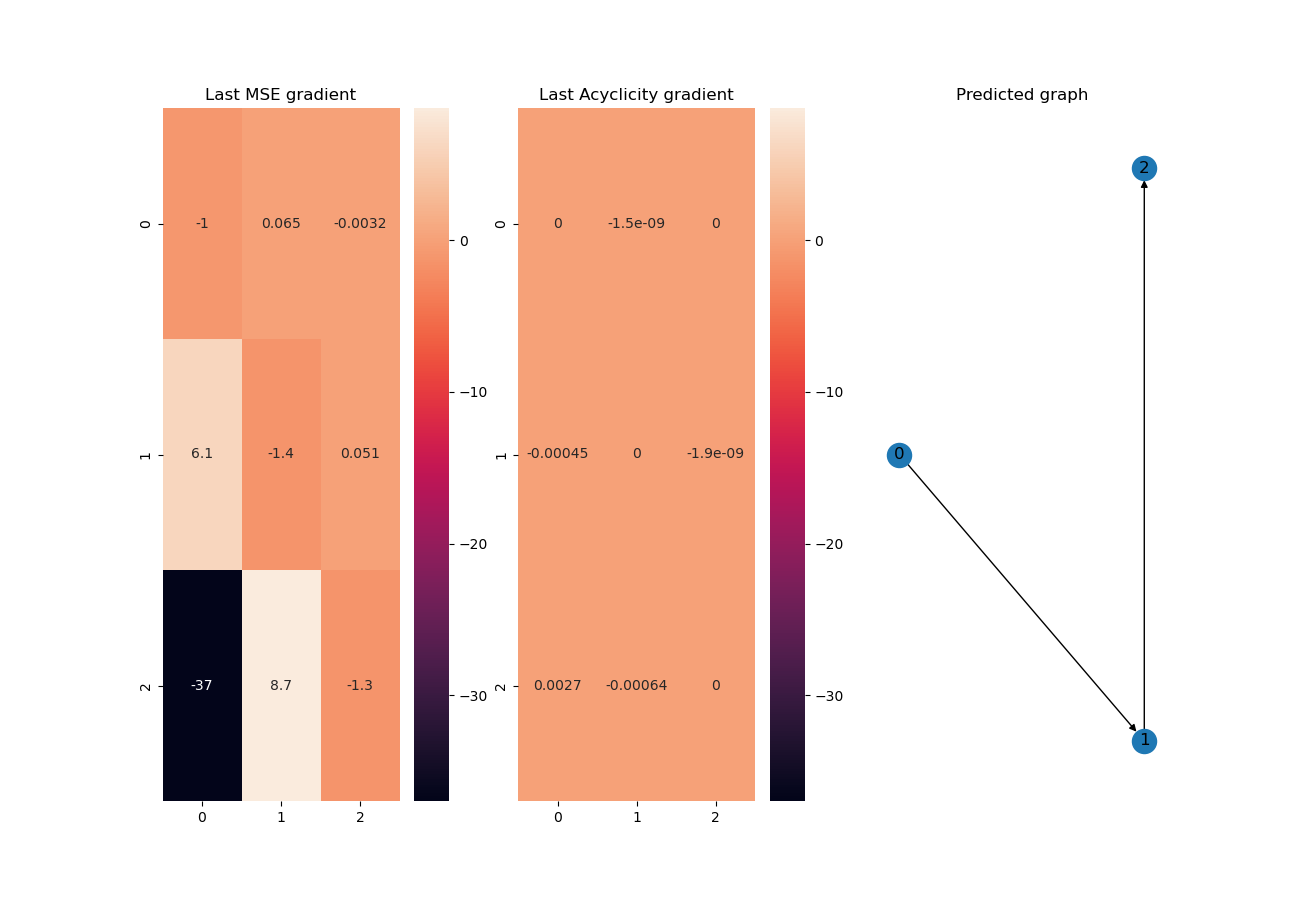

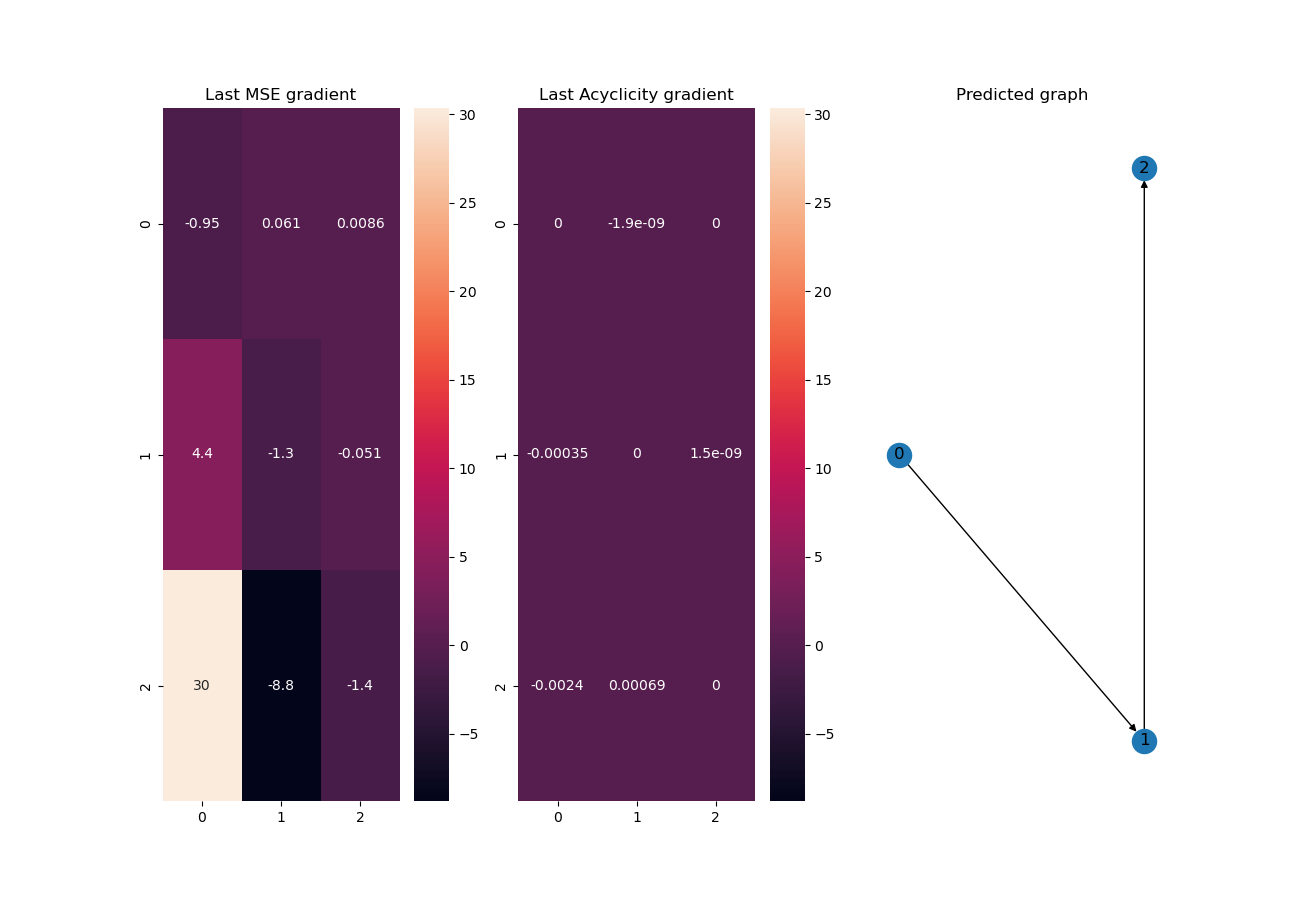

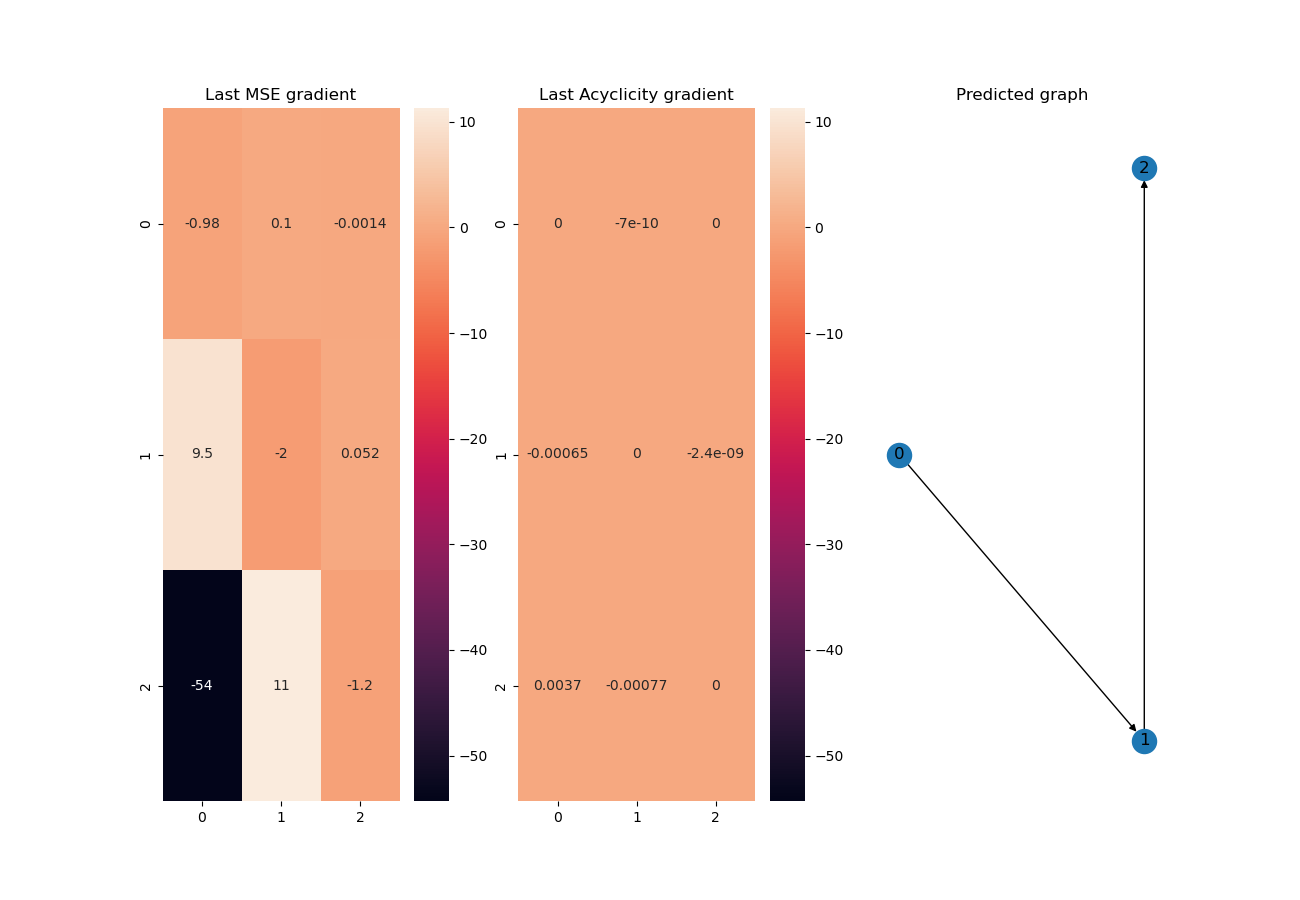

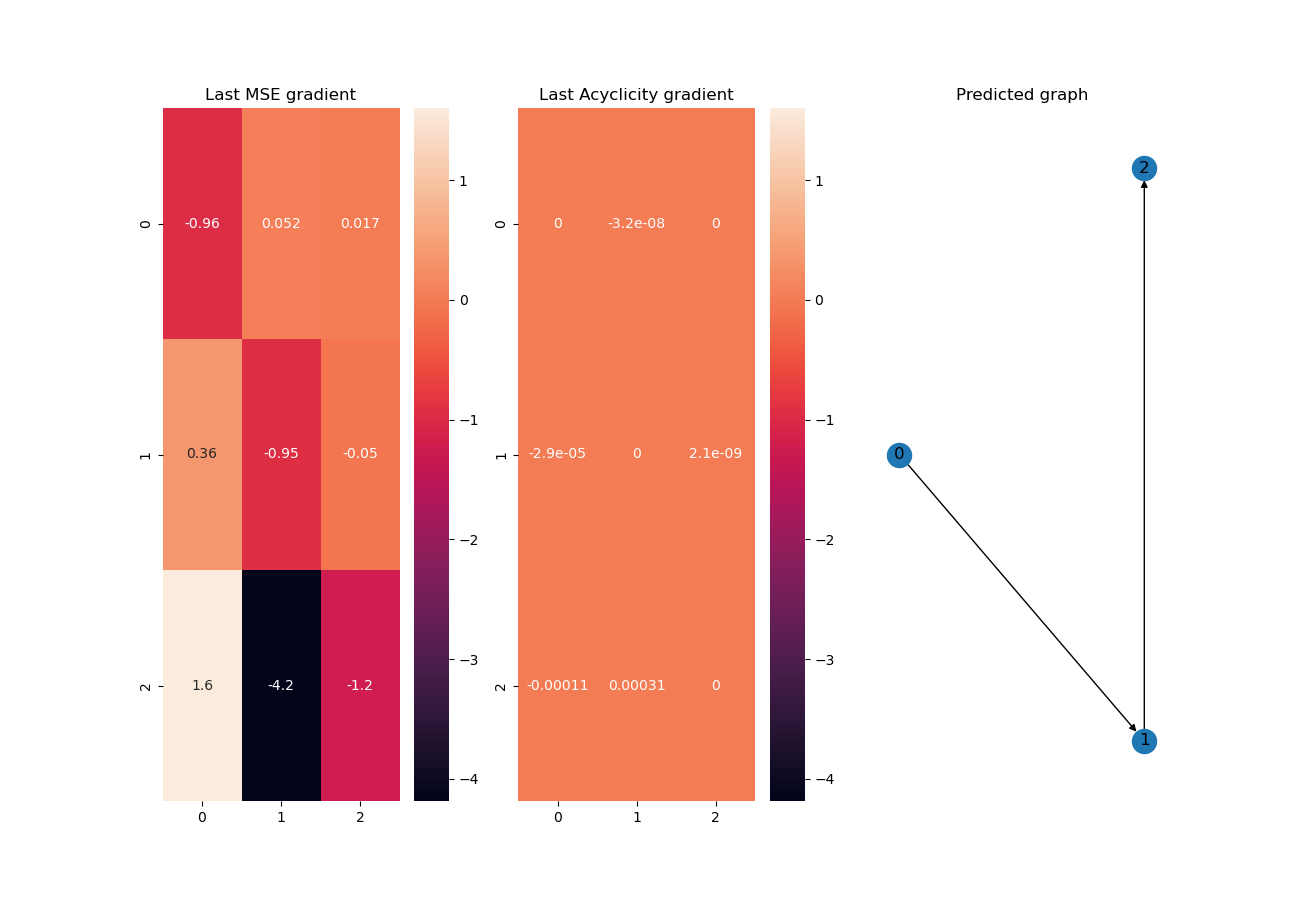

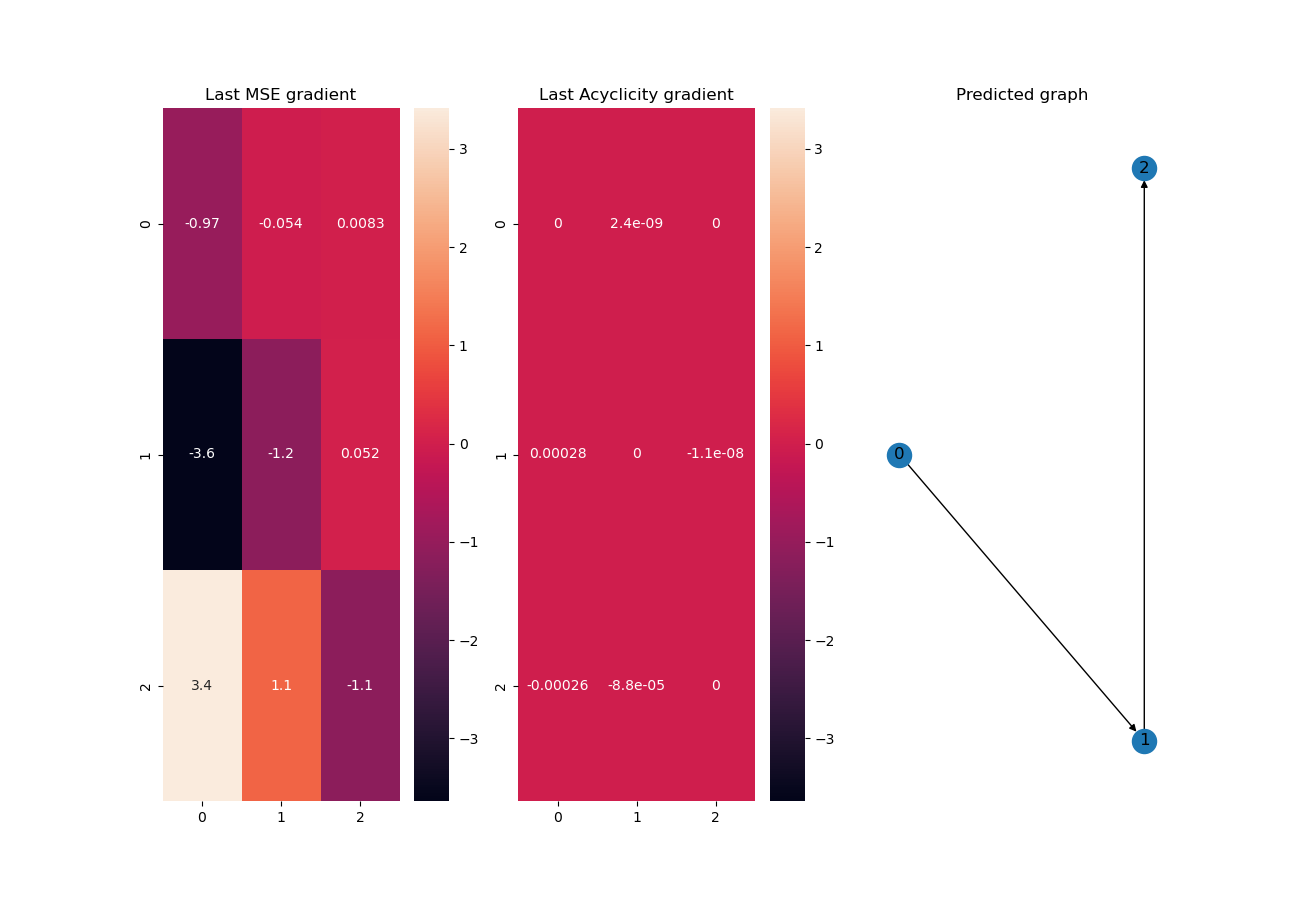

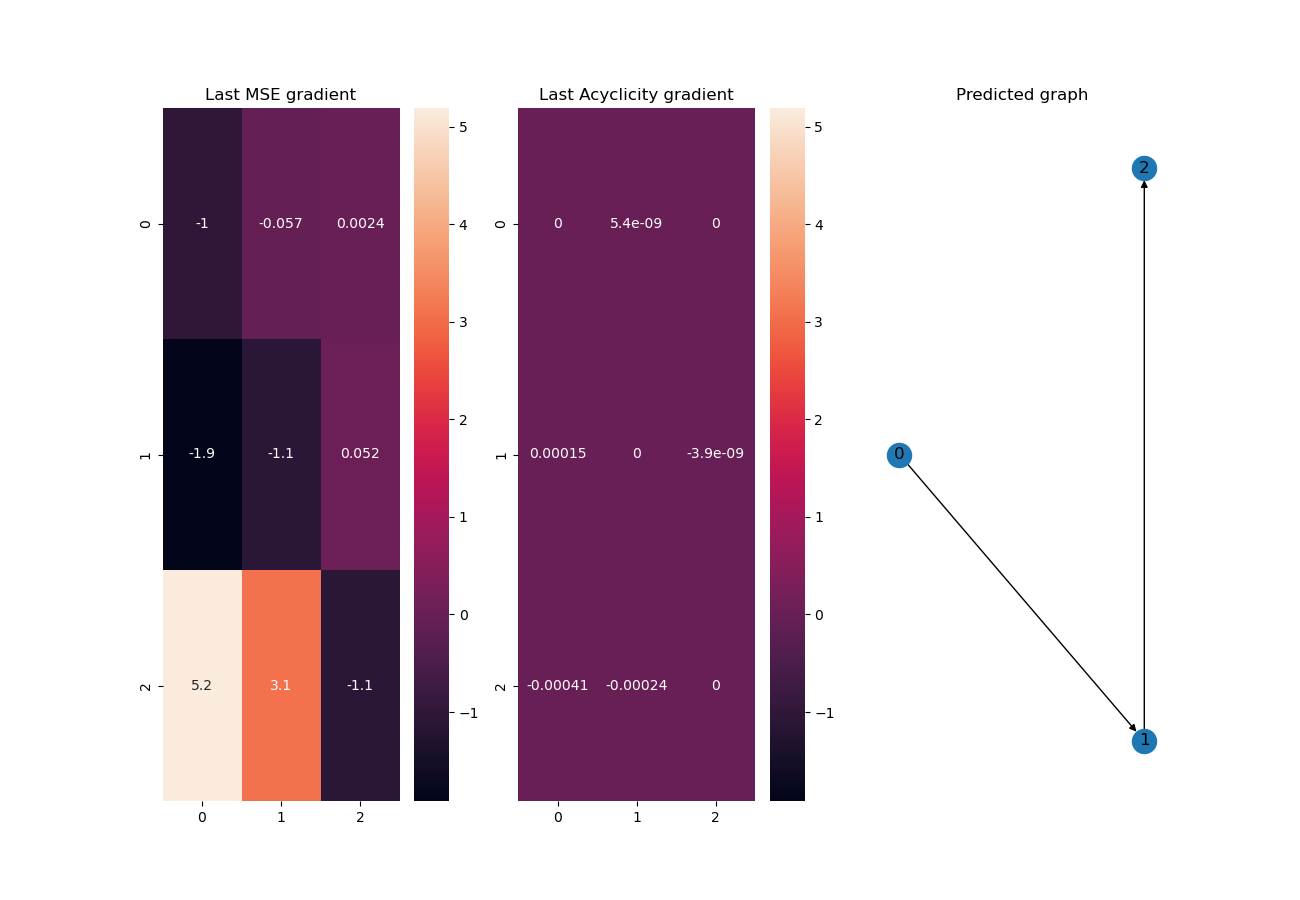

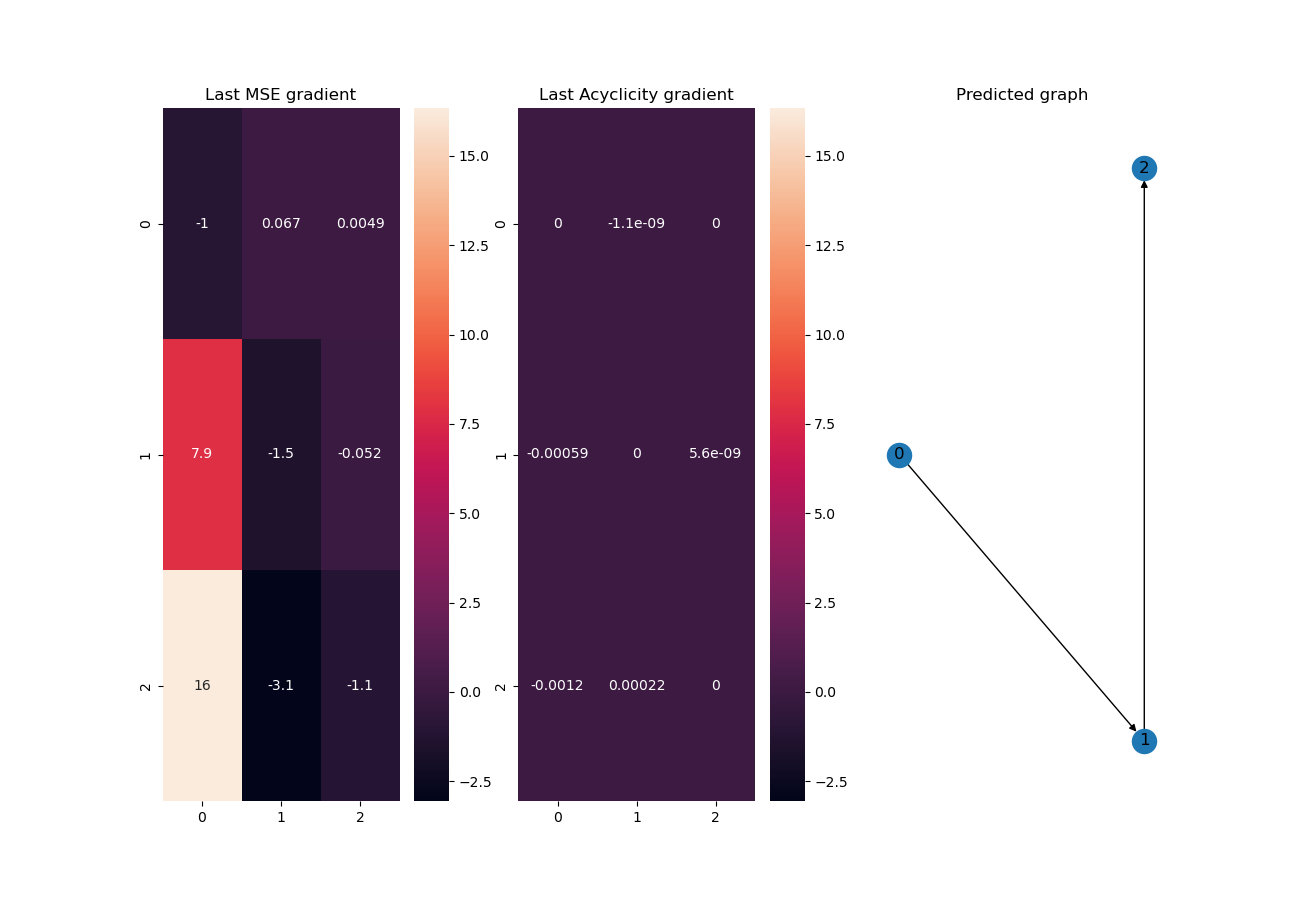

In [23]:
for i in range(0, 10):
    loss_gradient = pd.read_csv(loss_gradient_path.format(i), index_col=0)
    acyc_gradient = pd.read_csv(acyc_gradient_path.format(i), index_col=0)
    last_loss_grad = loss_gradient.tail(3)[['0', '1', '2']]
    last_acyc_grad = acyc_gradient.tail(3)[['0', '1', '2']]
    adj = predictions[i]
    G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)

    fig, axs = plt.subplots(1, 3, figsize=(13, 9))

    vmin = min(last_loss_grad.min().min(), last_acyc_grad.min().min())
    vmax = max(last_loss_grad.max().max(), last_acyc_grad.max().max())

    axs[0].set_title('Last MSE gradient')
    axs[1].set_title('Last Acyclicity gradient')
    axs[2].set_title('Predicted graph')

    sns.heatmap(last_loss_grad, vmin=vmin, vmax=vmax, ax=axs[0], annot=True)
    sns.heatmap(last_acyc_grad, vmin=vmin, vmax=vmax, ax=axs[1], annot=True)

    nx.draw_shell(G, ax=axs[2], with_labels=True)
    

## Identify graph types
Next, since we see above that NOTEARS makes several types of mistakes, we can analyze the following:
1. Which mistakes does NOTEARS make, i.e. which graphs does it output?
2. Which mistakes, i.e. which graphs, are most often the output of NOTEARS?
3. Is there a relationship between the coefficients and the type of mistake made by NOTEARS?

In [66]:
expected_adj = np.array([[0, 0, 0],
                        [1, 0, 0], 
                        [0, 1, 0]])

In [20]:
expected_adj = np.array([[0, 0],
                          [1, 0]])

In [58]:
known_adjs = []
coefficients = {}
for _, row in metadata_df.iterrows():
    pid, adj_nr = int(row['pid']), int(row['adj_nr'])
    coeffs = [row['s_1'], row['s_2']]
    adj = pd.read_csv(adj_path.format(pid, adj_nr), index_col=0).to_numpy()
    adj[adj != 0] = 1
    is_known = [np.all(adj == known_adj) for known_adj in known_adjs]
    if not np.any(is_known):
        adj_idx = len(known_adjs)
        known_adjs.append(adj)
        if adj_idx in coefficients.keys():
           coefficients[adj_idx].append(coeffs)
        else:
            coefficients[adj_idx] = [coeffs]
    elif len(known_adjs) > 0:
        adj_idx = np.argwhere(is_known)[0][0]
        coefficients[adj_idx].append(coeffs)

In [59]:
error_types = []
for idx, row in metadata_df.iterrows():
    pid, adj_nr = int(row['pid']), int(row['adj_nr'])
    adj = pd.read_csv(adj_path.format(pid, adj_nr), index_col=0).to_numpy()
    adj[adj != 0] = 1
    if np.all(adj == expected_adj):
        error_types.append(-5)
    else:
        for i, kadj in enumerate(known_adjs):
            if np.all(kadj == adj):
                error_types.append(i)

metadata_df['ErrorType'] = error_types

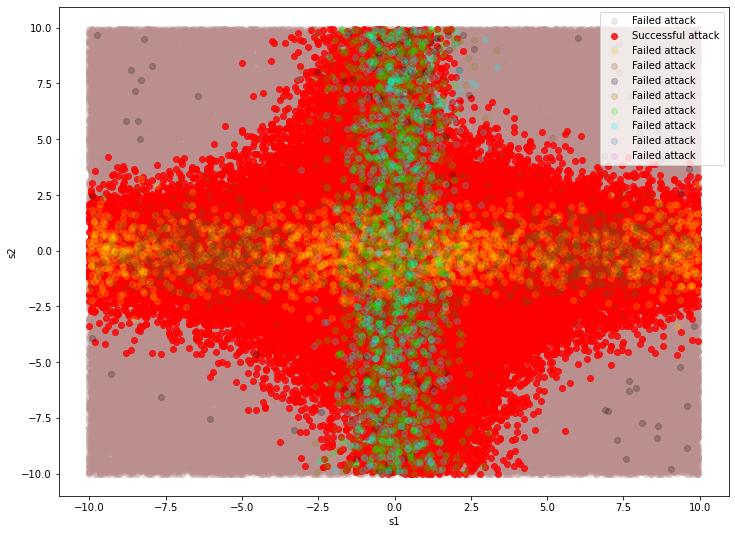

In [60]:
fig = plt.figure(figsize=(12, 9))
cm = plt.get_cmap('gist_rainbow')
ax = fig.add_subplot(111)
# colors = ['red', 'rosybrown', 'gold', 'saddlebrown', 'black', 'olive', 'lime', 'aqua', 'steelblue', 'violet', 'skyblue', 'deeppink']
colors = ['rosybrown', 'red', 'gold', 'saddlebrown', 'black', 'olive', 'lime', 'aqua', 'steelblue', 'violet', 'skyblue', 'deeppink']
# colors = ['green', 'blue', 'orange']
for idx, adj in enumerate(known_adjs):
    plt_coeffs = np.array(coefficients[idx])
    if np.all(adj == expected_adj):
        # plot correct predictions in blue
        scatter = ax.scatter(plt_coeffs[:, 0], plt_coeffs[:, 1], alpha=0.8)
        scatter.set_color(colors[idx])
        scatter.set_label('Successful attack')
    else:
        scatter = ax.scatter(plt_coeffs[:, 0], plt_coeffs[:, 1], alpha=0.2)
        scatter.set_color(colors[idx])
        scatter.set_label('Failed attack')
    
plt.xlabel('s1')
plt.ylabel('s2')
plt.legend()
plt.show()

In [17]:
def next_scales(s1_start, s1_end, s2_start, s2_end, step_size=0.05):
    s1, s2 = s1_start, s2_start
    if s1 < s1_end:
        yield (s1, s2)
        s1 += step_size
    elif not s1 < s1_end and s2 < s2_end:
        s1 = s1_start
        yield (s1, s2)
        s2 += step_size
    else:
        yield (s1_end, s2_end)

In [ ]:
fig = plt.figure(figsize=(12, 9))
plt.scatter(grid[])

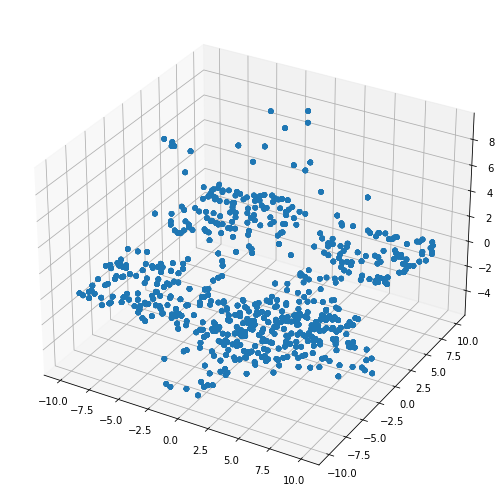

In [28]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(metadata_df['s_1'], metadata_df['s_2'], metadata_df['ErrorType'])
plt.show()

## Results
It can be seen that:
1. At least one parameter must be around 0 in order to make attack successful
2. Within the cross of successful attacks a higher variety of mistakes are made, however, the number of mistakes made is lower than outside the cross
3. Outside the cross we mainly see the same type of mistake made

The data indicate that there is a systematic way causing the attack to fail or succeed. The next steps are now:
1. Check what happens to dependence between two variables $X_1$ and $X_2$ if they are standardized and one is rescaled again.
2. Check if the choice of scale to artificially make data varsortable on success-rate of attack.

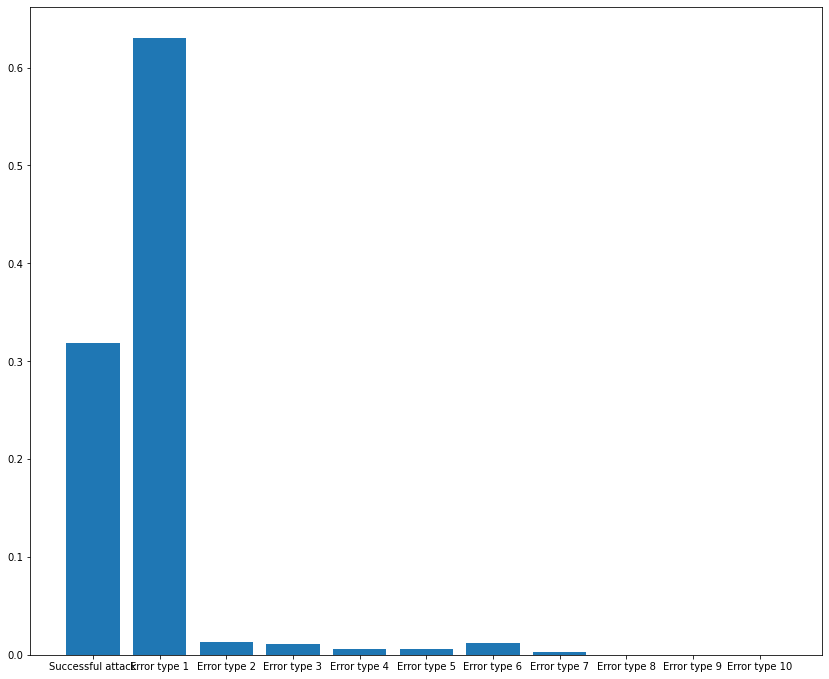

In [21]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_axes([0, 0, 1, 1])
heights = [len(coefficients[idx])/len(metadata_df) for idx in coefficients]
bars = ['Error type {}'.format(i) for i in range(0, len(known_adjs))]
success = [np.all(adj == expected_adj) for adj in known_adjs]
success_idx = np.argwhere(success)[0][0]
bars[success_idx] = 'Successful attack'
ax.bar(bars, heights)
plt.show()

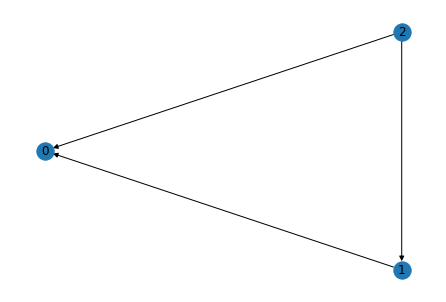

In [23]:
most_error_adj = known_adjs[1]
G = nx.convert_matrix.from_numpy_array(most_error_adj, create_using=nx.DiGraph)
nx.draw_shell(G, with_labels=True)

In [26]:
pos = nx.spring_layout(G)
for idx, adj in enumerate(known_adjs):
    G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors[idx])
    nx.draw_networkx_labels(G, pos)
    for edge in G.edges(data=True):
        w = 25
        nx.draw_networkx_edges(G, pos, edgelist=[(edge[0],edge[1])], arrowsize=w)
    plt.savefig('./images-fixed-data-wiggle/graph_{}.png'.format(idx))
    plt.close()

## Properties of Correlation and Covariance
- given two gaussians $X$, $Y$, the covariance depends on scale of both variables
- correlation does not depend on scale (since normalized by max. possible covariance)
- standardization of variables _does_ affect covariance, but _does not_ affect correlation (since the scale information is removed for each variable independently)
- upscaling a variable after standardizing all again has effect on covariance, but not on correlation
- max. covariance possible if both variables are standardized is 1 since it is the same as correlation in this case. This is because the variances are 1 in this case, i.e. the max covariance is 1*1
- covariance/correlation depends on scaling factor in data generating process and noise variance. I.e. the lower the fraction $\frac{\sigma^2}{s}$ is where $s$ is the scale and $\sigma^2$ the variance, the higher the covariance/correlation is. Makes sense because in relation there is less noise disturbing the variable resulting from scaling. In other words: The noise has lower weight than the scale-factor.

In [29]:
from sklearn.linear_model import Lasso

In [66]:
X0 = np.random.normal(0, 1, 1000)
X1 = 9*X0 + np.random.normal(0, 1, 1000)
X2 = 9*X1 + np.random.normal(0, 1, 1000)
data = np.array([X0, X1, X2]).T
sdata = scale(data)
sdata[:, 0] *= 3
X, Y = sdata[:, 1:], sdata[:, 0]

In [69]:
lasso = Lasso(0.05)
lasso.fit(X, Y)
lasso.coef_

array([2.93184652, 0.        ])

## Is NOTEARS deterministic?
In order to be able to exclude the conjecture that NOTEARS acts randomly itself, NOTEARS is applied on the same dataset 100 times. If all results are the same, we know that NOTEARS has no intrinsic randomness.

In [22]:
N0 = np.random.normal(0, 1, 1000)
#X1 = 2*X0 + np.random.normal(0, 1, 1000)
# X2 = 3*X1 + np.random.normal(0, 1, 1000)
N1 = np.random.normal(0, 1, 1000)
N2 = np.random.normal(0, 1, 1000)
scale_1 = np.random.uniform(-7, 7, 10)
scale_2 = np.random.uniform(-7, 7, 10)
all_equal = []
for i in range(0, 10):
    print("round {} / {}".format(i, 10))
    X0 = N0
    X1 = scale_1[i]*X0 + N1
    X2 = scale_2[i]*X1 + N2
    gdata = np.array([X0, X1, X2]).T
    gdata = scale(gdata)
    graphs = []
    for _ in range(0, 100):
        nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
        nt_pred[nt_pred != 0] = 1
        graphs.append(nt_pred)
    graphs_equal = all_graphs_equal(graphs)
    all_equal.append(graphs_equal)

round 0 / 10


KeyboardInterrupt: 

In [20]:
def all_graphs_equal(graphs):
    graphs = np.array(graphs)
    g0 = graphs[0]
    all_same = True
    for g in graphs:
        all_same = all_same and np.all(g == g0)
    return all_same

In [80]:
adjacencies = []
nodes = [0, 1, 2]
for edges in range(4):
    if edges == 0:
        adjacencies.append(np.zeros((3, 3)))
    else:
        inds = np.array(list(itertools.product(*(edges*(nodes, nodes)))))
        for edge_list in inds:
            adj = np.zeros((3, 3))
            edge_list = edge_list.reshape((-1, 2))
            for i, j in edge_list:
                adj[i, j] = 1

            adj_known = False
            for kadj in adjacencies:
                if np.all(kadj == adj) or np.all(adj == expected_adj):
                    adj_known = True
            if not adj_known:
                adjacencies.append(adj)
adjacencies.append(expected_adj)

In [81]:
possible_dags = []
for adj in adjacencies:
    g = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
    if nx.is_directed_acyclic_graph(g):
        possible_dags.append(g)

In [82]:
len(possible_dags)

25

In [69]:
def get_rand_colors():
    colors = np.random.choice(range(256), size=(24, 3))
    return colors

In [62]:
colors = get_rand_colors()

In [84]:
graph_name = 'dag_{}'
cdf = {'color': [], 'graph': []}
for n, g in enumerate(possible_dags):
    color = colors[n]
    color_string = '#%02x%02x%02x' % (color[0], color[1], color[2])
    gdf = nx.convert_matrix.to_pandas_adjacency(g)
    cdf['color'].append(color_string)
    cdf['graph'].append(graph_name.format(n))
    gdf.to_csv('./graphs/' + graph_name.format(n) + '.csv')
cdf = pd.DataFrame.from_dict(cdf)
cdf.to_csv('./color_scheme.csv')